In [1]:
import os
import tensorflow as tf
import glob
import shutil
import sys
import numpy as np
from skimage.io import imread
import pandas as pd
from keras.utils import generic_utils

2022-11-16 09:41:23.863065: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-11-16 09:41:23.970004: I tensorflow/core/util/util.cc:169] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2022-11-16 09:41:23.994059: E tensorflow/stream_executor/cuda/cuda_blas.cc:2981] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2022-11-16 09:41:24.422499: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; 

In [2]:
os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID"   
os.environ["CUDA_VISIBLE_DEVICES"]="1"

# Load Model

In [3]:
#load model
from tensorflow.keras.models import load_model

model_dir ='/media/tohn/SSD/ModelEfficientV2/OVRDT/5Class_model/R1_2/models/EffnetV2m_R1_5ClassOVRDT.h5'
model = load_model(model_dir)
height = width = model.input_shape[1]

2022-11-16 09:41:35.524332: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-11-16 09:41:35.942923: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1616] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 9629 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 2080 Ti, pci bus id: 0000:65:00.0, compute capability: 7.5


In [4]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 480, 480, 3  0           []                               
                                )]                                                                
                                                                                                  
 stem_conv (Conv2D)             (None, 240, 240, 24  648         ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 stem_bn (BatchNormalization)   (None, 240, 240, 24  96          ['stem_conv[0][0]']              
                                )                                                             

 )                              )                                0]']                             
                                                                                                  
 block2-02_project_bn (BatchNor  (None, 120, 120, 48  192        ['block2-02_project_conv[0][0]'] 
 malization)                    )                                                                 
                                                                                                  
 block2-02_drop (Dropout)       (None, 120, 120, 48  0           ['block2-02_project_bn[0][0]']   
                                )                                                                 
                                                                                                  
 block2-02_add (Add)            (None, 120, 120, 48  0           ['block2-02_drop[0][0]',         
                                )                                 'block2-01_project_bn[0][0]']   
          

 )                                                               0]']                             
                                                                                                  
 block3-01_project_bn (BatchNor  (None, 60, 60, 80)  320         ['block3-01_project_conv[0][0]'] 
 malization)                                                                                      
                                                                                                  
 block3-02_expand_conv (Conv2D)  (None, 60, 60, 320)  230400     ['block3-01_project_bn[0][0]']   
                                                                                                  
 block3-02_expand_bn (BatchNorm  (None, 60, 60, 320)  1280       ['block3-02_expand_conv[0][0]']  
 alization)                                                                                       
                                                                                                  
 block3-02

 block4-01_expand_bn (BatchNorm  (None, 60, 60, 320)  1280       ['block4-01_expand_conv[0][0]']  
 alization)                                                                                       
                                                                                                  
 block4-01_expand_activation (A  (None, 60, 60, 320)  0          ['block4-01_expand_bn[0][0]']    
 ctivation)                                                                                       
                                                                                                  
 block4-01_dwconv2 (DepthwiseCo  (None, 30, 30, 320)  2880       ['block4-01_expand_activation[0][
 nv2D)                                                           0]']                             
                                                                                                  
 block4-01_bn (BatchNormalizati  (None, 30, 30, 320)  1280       ['block4-01_dwconv2[0][0]']      
 on)      

                                                                                                  
 block4-03_bn (BatchNormalizati  (None, 30, 30, 640)  2560       ['block4-03_dwconv2[0][0]']      
 on)                                                                                              
                                                                                                  
 block4-03_activation (Activati  (None, 30, 30, 640)  0          ['block4-03_bn[0][0]']           
 on)                                                                                              
                                                                                                  
 block4-03_se_squeeze (GlobalAv  (None, 640)         0           ['block4-03_activation[0][0]']   
 eragePooling2D)                                                                                  
                                                                                                  
 block4-03

                                                                                                  
 block4-05_activation (Activati  (None, 30, 30, 640)  0          ['block4-05_bn[0][0]']           
 on)                                                                                              
                                                                                                  
 block4-05_se_squeeze (GlobalAv  (None, 640)         0           ['block4-05_activation[0][0]']   
 eragePooling2D)                                                                                  
                                                                                                  
 block4-05_se_reshape (Reshape)  (None, 1, 1, 640)   0           ['block4-05_se_squeeze[0][0]']   
                                                                                                  
 block4-05_se_reduce (Conv2D)   (None, 1, 1, 40)     25640       ['block4-05_se_reshape[0][0]']   
          

                                                                                                  
 block4-07_se_squeeze (GlobalAv  (None, 640)         0           ['block4-07_activation[0][0]']   
 eragePooling2D)                                                                                  
                                                                                                  
 block4-07_se_reshape (Reshape)  (None, 1, 1, 640)   0           ['block4-07_se_squeeze[0][0]']   
                                                                                                  
 block4-07_se_reduce (Conv2D)   (None, 1, 1, 40)     25640       ['block4-07_se_reshape[0][0]']   
                                                                                                  
 block4-07_se_expand (Conv2D)   (None, 1, 1, 640)    26240       ['block4-07_se_reduce[0][0]']    
                                                                                                  
 block4-07

                                                                                                  
 block5-02_se_expand (Conv2D)   (None, 1, 1, 1056)   47520       ['block5-02_se_reduce[0][0]']    
                                                                                                  
 block5-02_se_excite (Multiply)  (None, 30, 30, 1056  0          ['block5-02_activation[0][0]',   
                                )                                 'block5-02_se_expand[0][0]']    
                                                                                                  
 block5-02_project_conv (Conv2D  (None, 30, 30, 176)  185856     ['block5-02_se_excite[0][0]']    
 )                                                                                                
                                                                                                  
 block5-02_project_bn (BatchNor  (None, 30, 30, 176)  704        ['block5-02_project_conv[0][0]'] 
 malizatio

 block5-04_se_expand (Conv2D)   (None, 1, 1, 1056)   47520       ['block5-04_se_reduce[0][0]']    
                                                                                                  
 block5-04_se_excite (Multiply)  (None, 30, 30, 1056  0          ['block5-04_activation[0][0]',   
                                )                                 'block5-04_se_expand[0][0]']    
                                                                                                  
 block5-04_project_conv (Conv2D  (None, 30, 30, 176)  185856     ['block5-04_se_excite[0][0]']    
 )                                                                                                
                                                                                                  
 block5-04_project_bn (BatchNor  (None, 30, 30, 176)  704        ['block5-04_project_conv[0][0]'] 
 malization)                                                                                      
          

                                                                                                  
 block5-06_se_excite (Multiply)  (None, 30, 30, 1056  0          ['block5-06_activation[0][0]',   
                                )                                 'block5-06_se_expand[0][0]']    
                                                                                                  
 block5-06_project_conv (Conv2D  (None, 30, 30, 176)  185856     ['block5-06_se_excite[0][0]']    
 )                                                                                                
                                                                                                  
 block5-06_project_bn (BatchNor  (None, 30, 30, 176)  704        ['block5-06_project_conv[0][0]'] 
 malization)                                                                                      
                                                                                                  
 block5-06

 block5-08_se_excite (Multiply)  (None, 30, 30, 1056  0          ['block5-08_activation[0][0]',   
                                )                                 'block5-08_se_expand[0][0]']    
                                                                                                  
 block5-08_project_conv (Conv2D  (None, 30, 30, 176)  185856     ['block5-08_se_excite[0][0]']    
 )                                                                                                
                                                                                                  
 block5-08_project_bn (BatchNor  (None, 30, 30, 176)  704        ['block5-08_project_conv[0][0]'] 
 malization)                                                                                      
                                                                                                  
 block5-08_drop (Dropout)       (None, 30, 30, 176)  0           ['block5-08_project_bn[0][0]']   
          

                                )                                 'block5-10_se_expand[0][0]']    
                                                                                                  
 block5-10_project_conv (Conv2D  (None, 30, 30, 176)  185856     ['block5-10_se_excite[0][0]']    
 )                                                                                                
                                                                                                  
 block5-10_project_bn (BatchNor  (None, 30, 30, 176)  704        ['block5-10_project_conv[0][0]'] 
 malization)                                                                                      
                                                                                                  
 block5-10_drop (Dropout)       (None, 30, 30, 176)  0           ['block5-10_project_bn[0][0]']   
                                                                                                  
 block5-10

                                                                                                  
 block5-12_project_conv (Conv2D  (None, 30, 30, 176)  185856     ['block5-12_se_excite[0][0]']    
 )                                                                                                
                                                                                                  
 block5-12_project_bn (BatchNor  (None, 30, 30, 176)  704        ['block5-12_project_conv[0][0]'] 
 malization)                                                                                      
                                                                                                  
 block5-12_drop (Dropout)       (None, 30, 30, 176)  0           ['block5-12_project_bn[0][0]']   
                                                                                                  
 block5-12_add (Add)            (None, 30, 30, 176)  0           ['block5-12_drop[0][0]',         
          

 block5-14_project_conv (Conv2D  (None, 30, 30, 176)  185856     ['block5-14_se_excite[0][0]']    
 )                                                                                                
                                                                                                  
 block5-14_project_bn (BatchNor  (None, 30, 30, 176)  704        ['block5-14_project_conv[0][0]'] 
 malization)                                                                                      
                                                                                                  
 block5-14_drop (Dropout)       (None, 30, 30, 176)  0           ['block5-14_project_bn[0][0]']   
                                                                                                  
 block5-14_add (Add)            (None, 30, 30, 176)  0           ['block5-14_drop[0][0]',         
                                                                  'block5-13_add[0][0]']          
          

 block6-02_drop (Dropout)       (None, 15, 15, 304)  0           ['block6-02_project_bn[0][0]']   
                                                                                                  
 block6-02_add (Add)            (None, 15, 15, 304)  0           ['block6-02_drop[0][0]',         
                                                                  'block6-01_project_bn[0][0]']   
                                                                                                  
 block6-03_expand_conv (Conv2D)  (None, 15, 15, 1824  554496     ['block6-02_add[0][0]']          
                                )                                                                 
                                                                                                  
 block6-03_expand_bn (BatchNorm  (None, 15, 15, 1824  7296       ['block6-03_expand_conv[0][0]']  
 alization)                     )                                                                 
          

                                                                                                  
 block6-04_add (Add)            (None, 15, 15, 304)  0           ['block6-04_drop[0][0]',         
                                                                  'block6-03_add[0][0]']          
                                                                                                  
 block6-05_expand_conv (Conv2D)  (None, 15, 15, 1824  554496     ['block6-04_add[0][0]']          
                                )                                                                 
                                                                                                  
 block6-05_expand_bn (BatchNorm  (None, 15, 15, 1824  7296       ['block6-05_expand_conv[0][0]']  
 alization)                     )                                                                 
                                                                                                  
 block6-05

 block6-06_add (Add)            (None, 15, 15, 304)  0           ['block6-06_drop[0][0]',         
                                                                  'block6-05_add[0][0]']          
                                                                                                  
 block6-07_expand_conv (Conv2D)  (None, 15, 15, 1824  554496     ['block6-06_add[0][0]']          
                                )                                                                 
                                                                                                  
 block6-07_expand_bn (BatchNorm  (None, 15, 15, 1824  7296       ['block6-07_expand_conv[0][0]']  
 alization)                     )                                                                 
                                                                                                  
 block6-07_expand_activation (A  (None, 15, 15, 1824  0          ['block6-07_expand_bn[0][0]']    
 ctivation

                                                                  'block6-07_add[0][0]']          
                                                                                                  
 block6-09_expand_conv (Conv2D)  (None, 15, 15, 1824  554496     ['block6-08_add[0][0]']          
                                )                                                                 
                                                                                                  
 block6-09_expand_bn (BatchNorm  (None, 15, 15, 1824  7296       ['block6-09_expand_conv[0][0]']  
 alization)                     )                                                                 
                                                                                                  
 block6-09_expand_activation (A  (None, 15, 15, 1824  0          ['block6-09_expand_bn[0][0]']    
 ctivation)                     )                                                                 
          

                                                                                                  
 block6-11_expand_conv (Conv2D)  (None, 15, 15, 1824  554496     ['block6-10_add[0][0]']          
                                )                                                                 
                                                                                                  
 block6-11_expand_bn (BatchNorm  (None, 15, 15, 1824  7296       ['block6-11_expand_conv[0][0]']  
 alization)                     )                                                                 
                                                                                                  
 block6-11_expand_activation (A  (None, 15, 15, 1824  0          ['block6-11_expand_bn[0][0]']    
 ctivation)                     )                                                                 
                                                                                                  
 block6-11

 block6-13_expand_conv (Conv2D)  (None, 15, 15, 1824  554496     ['block6-12_add[0][0]']          
                                )                                                                 
                                                                                                  
 block6-13_expand_bn (BatchNorm  (None, 15, 15, 1824  7296       ['block6-13_expand_conv[0][0]']  
 alization)                     )                                                                 
                                                                                                  
 block6-13_expand_activation (A  (None, 15, 15, 1824  0          ['block6-13_expand_bn[0][0]']    
 ctivation)                     )                                                                 
                                                                                                  
 block6-13_dwconv2 (DepthwiseCo  (None, 15, 15, 1824  16416      ['block6-13_expand_activation[0][
 nv2D)    

                                )                                                                 
                                                                                                  
 block6-15_expand_bn (BatchNorm  (None, 15, 15, 1824  7296       ['block6-15_expand_conv[0][0]']  
 alization)                     )                                                                 
                                                                                                  
 block6-15_expand_activation (A  (None, 15, 15, 1824  0          ['block6-15_expand_bn[0][0]']    
 ctivation)                     )                                                                 
                                                                                                  
 block6-15_dwconv2 (DepthwiseCo  (None, 15, 15, 1824  16416      ['block6-15_expand_activation[0][
 nv2D)                          )                                0]']                             
          

                                                                                                  
 block6-17_expand_bn (BatchNorm  (None, 15, 15, 1824  7296       ['block6-17_expand_conv[0][0]']  
 alization)                     )                                                                 
                                                                                                  
 block6-17_expand_activation (A  (None, 15, 15, 1824  0          ['block6-17_expand_bn[0][0]']    
 ctivation)                     )                                                                 
                                                                                                  
 block6-17_dwconv2 (DepthwiseCo  (None, 15, 15, 1824  16416      ['block6-17_expand_activation[0][
 nv2D)                          )                                0]']                             
                                                                                                  
 block6-17

 block7-01_expand_bn (BatchNorm  (None, 15, 15, 1824  7296       ['block7-01_expand_conv[0][0]']  
 alization)                     )                                                                 
                                                                                                  
 block7-01_expand_activation (A  (None, 15, 15, 1824  0          ['block7-01_expand_bn[0][0]']    
 ctivation)                     )                                                                 
                                                                                                  
 block7-01_dwconv2 (DepthwiseCo  (None, 15, 15, 1824  16416      ['block7-01_expand_activation[0][
 nv2D)                          )                                0]']                             
                                                                                                  
 block7-01_bn (BatchNormalizati  (None, 15, 15, 1824  7296       ['block7-01_dwconv2[0][0]']      
 on)      

 block7-03_dwconv2 (DepthwiseCo  (None, 15, 15, 3072  27648      ['block7-03_expand_activation[0][
 nv2D)                          )                                0]']                             
                                                                                                  
 block7-03_bn (BatchNormalizati  (None, 15, 15, 3072  12288      ['block7-03_dwconv2[0][0]']      
 on)                            )                                                                 
                                                                                                  
 block7-03_activation (Activati  (None, 15, 15, 3072  0          ['block7-03_bn[0][0]']           
 on)                            )                                                                 
                                                                                                  
 block7-03_se_squeeze (GlobalAv  (None, 3072)        0           ['block7-03_activation[0][0]']   
 eragePool

 nv2D)                          )                                0]']                             
                                                                                                  
 block7-05_bn (BatchNormalizati  (None, 15, 15, 3072  12288      ['block7-05_dwconv2[0][0]']      
 on)                            )                                                                 
                                                                                                  
 block7-05_activation (Activati  (None, 15, 15, 3072  0          ['block7-05_bn[0][0]']           
 on)                            )                                                                 
                                                                                                  
 block7-05_se_squeeze (GlobalAv  (None, 3072)        0           ['block7-05_activation[0][0]']   
 eragePooling2D)                                                                                  
          

# DATA

In [5]:
#Train
dataframe = pd.read_csv('/media/tohn/HDD/VISION_dataset/DATA_OVRDT/CSV/azure_ovrdtDB_Alllevel_2640imgs_round12_train.csv')
dataframe = dataframe[dataframe['class'] != 5].reset_index(drop=True)
dataframe['class'] = dataframe['class'].astype(str)
print(dataframe.shape)
dataframe.head()

#validation
valframe = pd.read_csv('/media/tohn/HDD/VISION_dataset/DATA_OVRDT/CSV/azure_ovrdtDB_Alllevel_300imgs_round1_test.csv') #เปลี่ยนตาม fold
valframe = valframe[valframe['class'] != 5].reset_index(drop=True)
valframe['class'] = valframe['class'].astype(str)
print(valframe.shape)
valframe.head()

DATA_PATH = "/media/tohn/HDD/VISION_dataset/DATA_OVRDT/ovrdtDB_08_06_65_from_AjOP_labeled/ovrdtDB_1"
os.chdir(DATA_PATH)
train_dir = os.path.join(DATA_PATH, 'train')
print(train_dir)
validation_dir = os.path.join(DATA_PATH, 'validation')
print(validation_dir)

(2211, 11)
(235, 10)
/media/tohn/HDD/VISION_dataset/DATA_OVRDT/ovrdtDB_08_06_65_from_AjOP_labeled/ovrdtDB_1/train
/media/tohn/HDD/VISION_dataset/DATA_OVRDT/ovrdtDB_08_06_65_from_AjOP_labeled/ovrdtDB_1/validation


In [6]:
#Setting data loader
batch_size = 32

from tensorflow.keras.preprocessing.image import ImageDataGenerator

train_datagen = ImageDataGenerator(
      rescale=1./255,
      rotation_range=30,
      width_shift_range=0.2,
      height_shift_range=0.2,
      brightness_range=[0.5,1.5],
      shear_range=0.4,
      zoom_range=0.2,
      horizontal_flip=False,
      fill_mode='nearest')

train_generator = train_datagen.flow_from_dataframe(
        dataframe = valframe,
        directory = validation_dir,
        x_col = 'path',
        y_col = 'class',
        target_size = (height, width),
        batch_size=batch_size,
        color_mode= 'rgb',
        class_mode='categorical')

#label
labels = (train_generator.class_indices)
labels = dict((v,k) for k,v in labels.items())
print(labels)

Found 235 validated image filenames belonging to 5 classes.
{0: '0', 1: '1', 2: '2', 3: '3', 4: '4'}


## Predict Step

In [7]:
from tensorflow.keras.preprocessing import image

def predict_image(img_path):
    # Read the image and resize it
    img = image.load_img(img_path, target_size=(height, width))
    # Convert it to a Numpy array with target shape.
    x = image.img_to_array(img)
    # Reshape
    x = x.reshape((1,) + x.shape)
    x /= 255.
    result = model.predict([x])
    return result[0]

#Predict
pred_list = list()
prob_list = list()
img_path=valframe['path'].tolist()
for i in range(0,len(img_path)):
    predict = predict_image(img_path[i])
    result = np.argmax(predict)
    pred_list.append(labels[result])
    prob_list.append(predict[result])

2022-11-16 09:45:25.425463: I tensorflow/stream_executor/cuda/cuda_dnn.cc:384] Loaded cuDNN version 8100
2022-11-16 09:45:25.801822: I tensorflow/core/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory


1/1 [==============================] - 0s 53ms/step


1/1 [==============================] - 0s 50ms/step


In [8]:
# img = image.load_img(valframe['path'][299], target_size=(height, width))
# # Convert it to a Numpy array with target shape.
# x = image.img_to_array(img)
# # Reshape
# x = x.reshape((1,) + x.shape)
# x /= 255.
# result = model.predict([x])
# result

In [9]:
valframe['category_ov'] = pred_list
valframe['Prob_ov'] = prob_list
print(valframe.shape)
valframe.head()

(235, 12)


,Unnamed: 0,fileName,class,path,path_filename,ov_level,ov,path_crop,OSofRec,data,category_ov,Prob_ov
0,15,binzpovayv.png.jpg,0,/media/tohn/HDD/VISION_dataset/DATA_OVRDT/ovrd...,/media/tohn/HDD/VISION_dataset/DATA_OVRDT/imag...,1.0,1.0,/media/tohn/HDD/VISION_dataset/DATA_OVRDT/imag...,Android,train,0,0.397609
1,20,aeetooklxt.png.jpg,0,/media/tohn/HDD/VISION_dataset/DATA_OVRDT/ovrd...,/media/tohn/HDD/VISION_dataset/DATA_OVRDT/imag...,0.0,0.0,/media/tohn/HDD/VISION_dataset/DATA_OVRDT/imag...,Android,train,4,0.237368
2,21,axycvnaxjp.png.jpg,0,/media/tohn/HDD/VISION_dataset/DATA_OVRDT/ovrd...,/media/tohn/HDD/VISION_dataset/DATA_OVRDT/imag...,0.0,0.0,/media/tohn/HDD/VISION_dataset/DATA_OVRDT/imag...,Android,train,3,0.291829
3,24,dozunkkhvm.png.jpg,0,/media/tohn/HDD/VISION_dataset/DATA_OVRDT/ovrd...,/media/tohn/HDD/VISION_dataset/DATA_OVRDT/imag...,0.0,0.0,/media/tohn/HDD/VISION_dataset/DATA_OVRDT/imag...,Android,train,1,0.310381
4,25,dtmvydboay.png.jpg,0,/media/tohn/HDD/VISION_dataset/DATA_OVRDT/ovrd...,/media/tohn/HDD/VISION_dataset/DATA_OVRDT/imag...,0.0,0.0,/media/tohn/HDD/VISION_dataset/DATA_OVRDT/imag...,Android,train,1,0.237441


In [10]:
data_train = valframe
#เช็คคลาสใน Predicted
pred_class = set(data_train['category_ov'])
print('Predicted : ',len(pred_class))
print(pred_class)
print('-'*50)
#เช็คคลาสใน Actual
classe = set(data_train['class'])
print('Actual : ',len(classe))
print(classe)

Predicted :  5
{'0', '1', '3', '4', '2'}
--------------------------------------------------
Actual :  5
{'0', '1', '3', '4', '2'}


In [11]:
import numpy as np
from sklearn.metrics import confusion_matrix

act = data_train['class'].array
pred = data_train['category_ov'].array

cmat = confusion_matrix(act, pred)
print('classifier accuracy = {}%'.format((100.*np.trace(cmat))/(np.sum(cmat))))

#Marking the Confusion Matrix
from sklearn.metrics import classification_report,confusion_matrix
print(classification_report(act, pred))#performance

classifier accuracy = 24.680851063829788%
              precision    recall  f1-score   support

           0       0.48      0.33      0.39        45
           1       0.21      0.20      0.20        46
           2       0.21      0.15      0.17        55
           3       0.19      0.40      0.26        43
           4       0.28      0.20      0.23        46

    accuracy                           0.25       235
   macro avg       0.27      0.25      0.25       235
weighted avg       0.27      0.25      0.25       235



Text(0.5, 21.249999999999993, 'Predicted label')

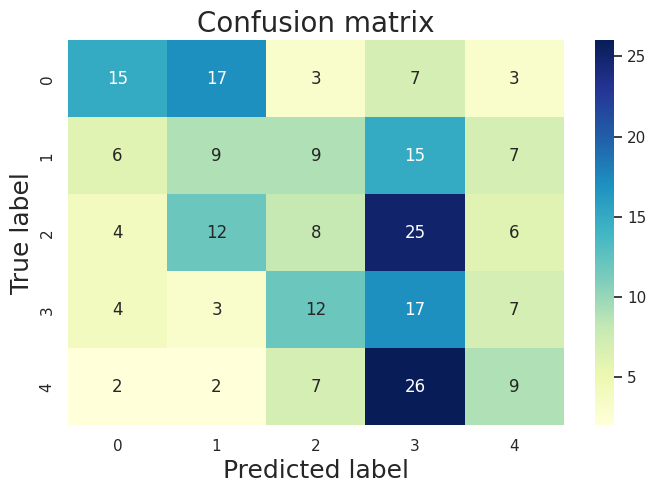

In [12]:
#create CF 
data = {'Actual': act,'Predicted' : pred,}
df = pd.DataFrame(data, columns=['Actual','Predicted'])
conf_mat = pd.crosstab(df['Actual'],df['Predicted'],rownames=['Actual'],colnames=['Predicted'])

#Confusion matrix
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
cm = confusion_matrix(act, pred)

#plot Confusion matrix
import seaborn as sns
sns.set()
fig, ax = plt.subplots(figsize=(8, 5))

ax = sns.heatmap(conf_mat, annot=True, fmt="d", cmap="YlGnBu") #Blues,Oranges,Reds
ax.set_title('Confusion matrix',fontsize=20)
ax.set_ylabel('True label',fontsize=18)
ax.set_xlabel('Predicted label',fontsize=18)